In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from random import randint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
# Assuming train, test, and validation datasets are provided as separate directories
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"  # Replace with the path to your training dataset
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"    # Replace with the path to your testing dataset
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"  # Replace with the path to your validation dataset
img_height, img_width = 28, 28  # Adjust dimensions based on your dataset
batch_size = 64


In [18]:
# Use ImageDataGenerator to load images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode="grayscale",  # Change to 'rgb' if your dataset has color images
    batch_size=batch_size,
    class_mode='categorical',  # Unsupervised learning (autoencoder)
    shuffle=True
)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
# Prepare datasets
x_train = np.concatenate([train_generator[i][0] for i in range(len(train_generator))])
x_val = np.concatenate([validation_generator[i][0] for i in range(len(validation_generator))])
x_test = np.concatenate([test_generator[i][0] for i in range(len(test_generator))])


In [21]:
# Encoder
hidden_size = 128
latent_size = 20

input_layer = layers.Input(shape=(img_height, img_width, 1))  # Adjust for grayscale images
flattened = layers.Flatten()(input_layer)
hidden = layers.Dense(hidden_size, activation='relu')(flattened)
latent = layers.Dense(latent_size, activation='tanh')(hidden)
encoder = Model(inputs=input_layer, outputs=latent, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,060 (402.58 KB)

 Trainable params: 103,060 (402.58 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Decoder
input_layer_decoder = layers.Input(shape=encoder.output.shape[1:])
upsampled = layers.Dense(hidden_size, activation='relu')(input_layer_decoder)
target_shape = img_height * img_width  # Total number of elements in the original input shape
upsampled = layers.Dense(target_shape, activation='sigmoid')(upsampled)
constructed = layers.Reshape((img_height, img_width, 1))(upsampled)
decoder = models.Model(inputs=input_layer_decoder, outputs=constructed, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,824 (405.56 KB)

 Trainable params: 103,824 (405.56 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Autoencoder
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       103,824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,884 (808.14 KB)

 Trainable params: 206,884 (808.14 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(
    x_train, x_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(x_val, x_val),
    verbose=1
)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0369 - val_loss: 0.0237
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214 - val_loss: 0.0194
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - val_loss: 0.0161
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0155 - val_loss: 0.0145
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

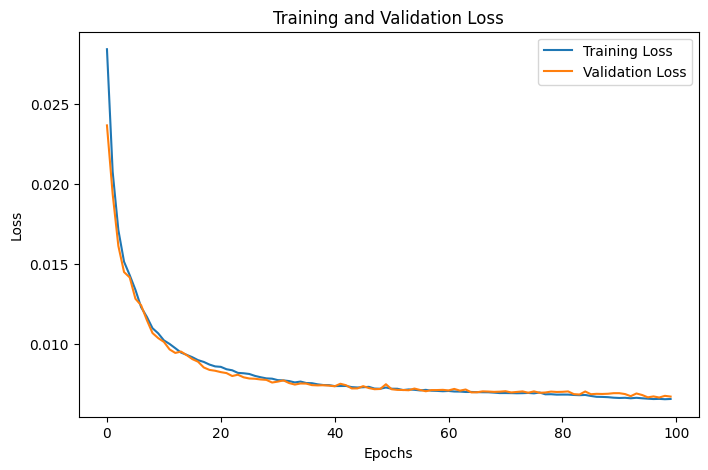

In [26]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


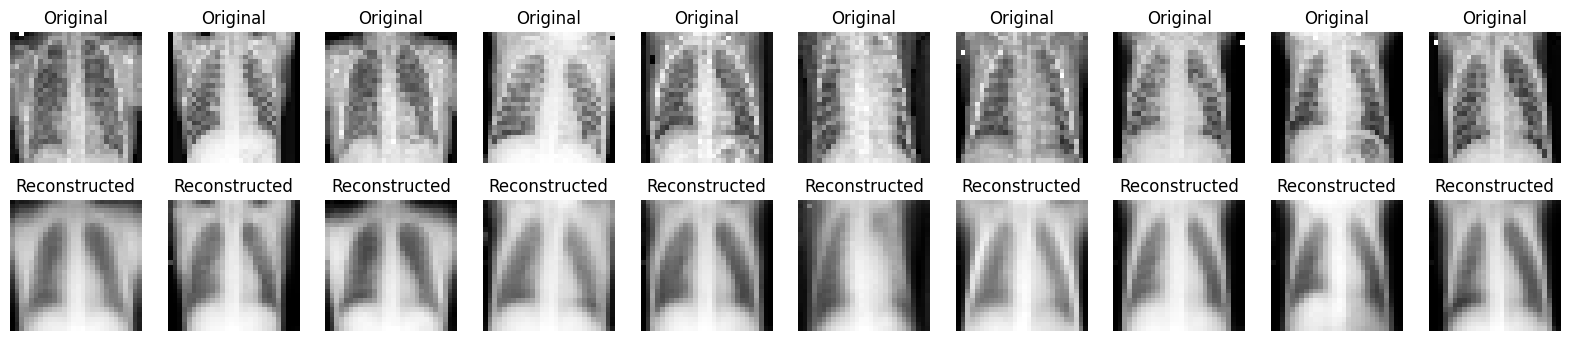

In [27]:
# Visualize reconstructed images
n = 10  # Number of samples to display
indices = np.random.choice(range(len(x_test)), n, replace=False)
test_samples = x_test[indices]
reconstructed_samples = autoencoder.predict(test_samples)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_samples[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_samples[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()